# Описание проекта

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов

<b>Тариф «Смарт»</b>


1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
   - минута разговора: 3 рубля
   - сообщение: 3 рубля
   - 1 Гб интернет-трафика: 200 рублей
   
<b>Тариф «Ультра»</b>


1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
   - минута разговора: 1 рубль
   - сообщение: 1 рубль
   - 1 Гб интернет-трафика: 150 рублей

<b>Примечание:</b>

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.


Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Загрузка и изучение данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv', index_col = 'Unnamed: 0')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')
datasets = [calls, internet, messages, tariffs, users]

In [2]:
for dataset in datasets:
    print('Датасет')
    dataset.info()
    print('-----------------------')
    print(dataset.describe())
    print('-----------------------')
    print(dataset.head())
    print()
    print('/////////////////////////////////////////////////////////////////////////////')
    print()

Датасет
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
-----------------------
            duration        user_id
count  202607.000000  202607.000000
mean        6.755887    1253.940619
std         5.843365     144.722751
min         0.000000    1000.000000
25%         1.300000    1126.000000
50%         6.000000    1260.000000
75%        10.700000    1379.000000
max        38.000000    1499.000000
-----------------------
       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     10

Пропущенные значения имеются лишь в одном столбце 'churn_date' в датасете 'users'. Этот параметр отображает дату прекращения использования тарифа, если значение пропущено, значит данный клиент все еще пользовался тарифом на момент выгрузки данных. Оставим эти пропущенные значения, они имеют смысл.

## Изменение типов данных

Плата за тариф взимается 1 раз в месяц, соответственно и продолжительность разговоров (в минутах), количество сообщений, количество интернет-трафика учитывается за месяц. Для того, чтобы отслеживать эти данные с точностью до месяцев, необходимо в таблицах <b>calls, internet, messages</b> изменить тип данных в столбцах <b>call_date, session_date, message_date</b> соответственно на тип <b>'datetime64'</b>.

Также в таблице <b>users</b> необходимо изменить тип данных столбцов <b>churn_date, reg_date</b> на тип <b>datetime64</b>.

In [3]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [4]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


In [5]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [6]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d', errors='ignore')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Тип данных изменен.

## Анализ данных на ошибки и аномалии

### Таблица звонков 'calls'

Рассмотрим каждую таблицу подробнее. Первая - <b>calls</b>. Для начала приведем значения столбца <b>'duration'</b> к принципу нашего оператора: округлять длительность звонков в большую сторону.

In [7]:
calls['duration'] = np.ceil(calls['duration'])
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


In [8]:
calls.head(50)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000
5,1000_5,2018-11-02,0.0,1000
6,1000_6,2018-10-18,0.0,1000
7,1000_7,2018-08-22,19.0,1000
8,1000_8,2018-09-15,19.0,1000
9,1000_9,2018-08-15,0.0,1000


In [9]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,7.158198,1253.940619
std,5.959173,144.722751
min,0.000000,1000.000000
25%,2.000000,1126.000000
50%,6.000000,1260.000000
75%,11.000000,1379.000000
max,38.000000,1499.000000


Средняя длительность разговора: 7.15 мин.

Медиана длительности разговора: 6 мин.

Максимальная длительность разговора: 38 мин.

<b>Минимальная длительность разговора: 0 мин.</b>

Вспомним примечание к задаче, в котором написано: <b>Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.</b>

Но мы видим нулевые значения, это странно, вероятнее всего это <b>пропущенные звонки</b>, клиент просто не дозвонился.

Необходимо устранить эту <b>'аномалию'</b>, можно сделать это несколькими способами:

- Заполнить эти значения медианой продолжительности разговора;
- Удалить данные с нулевой продолжительностью разговора;
- Оставить данные с нулевой длительностью.

Считаю, что правильным способом будет <b>удаление таких данных</b>, так как они изменяют показатели "средней продолжительности разговора" и "медианы продолжительности разговора", а также изменяют количество звонков в целом, что может отразиться на результатах анализа данных.

Средняя длительность звонков: 7.16
Медиана длительности звонков: 6.00
Стандартное отклонение: 5.96


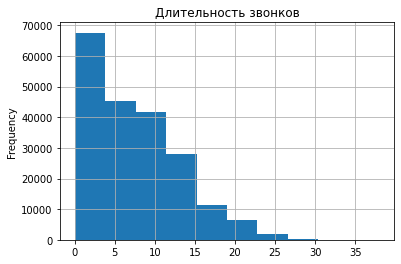

In [10]:
# Гистограмма длительности звонков учитывая нулевые значения
calls['duration'].plot(kind='hist', grid=True, title='Длительность звонков')
print('Средняя длительность звонков: {:.2f}'.format(calls['duration'].mean()))
print('Медиана длительности звонков: {:.2f}'.format(calls['duration'].median()))
print('Стандартное отклонение: {:.2f}'.format(np.std(calls['duration'])))

Средняя длительность звонков: 8.90
Медиана длительности звонков: 8.00
Стандартное отклонение: 5.35


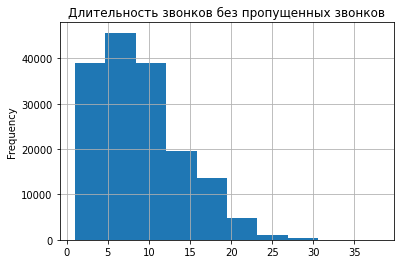

In [11]:
# Гистограмма длительности звонков не учитывая нулевые значения
calls.query('duration > 0')['duration'].plot(kind='hist', grid=True, title='Длительность звонков без пропущенных звонков')
print('Средняя длительность звонков: {:.2f}'.format(calls.query('duration > 0')['duration'].mean()))
print('Медиана длительности звонков: {:.2f}'.format(calls.query('duration > 0')['duration'].median()))
print('Стандартное отклонение: {:.2f}'.format(np.std(calls.query('duration > 0')['duration'])))

Среднее значение, медиана, а также стандартное отклонение заметно меняются, если не учитывать "пропущенные звонки", а также распределение длительности звонков стремится к нормальному.

Подведем итог после удаления данных:

- Средняя длительность и медиана увеличились, очевидно, что они стали более правдоподобными;
- Стандартное отклонение уменьшилось;
- Количество "полноценных" звонков теперь действительно.

Единственный минус данного способа: мы удалили часть звонков, пускай они и пропущенные (пустые), но их количество может нам рассказать об активности "пользователя". В любом случае, активность могла бы дать нам лишь догадки о количестве звонков пользователя, например, в следующем месяце. В нашем случае мы анализируем использованное количество минут.

In [12]:
calls = calls.query('duration > 0').reset_index(drop=True)

In [13]:
print('Количество строк после удаления "пропущенных звонков": {}'.format(calls.shape[0]))

Количество строк после удаления "пропущенных звонков": 162994


### Таблица интернет трафика 'internet'

Вторая таблица для подробного рассмотрения - <b>internet</b>.

In [14]:
internet.head(50)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [15]:
internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


В данной таблице мы также можем наблюдать <b>"нулевые" сессии</b> - потраченный интернет трафик составляет 0.0. Я считаю, что в действительности такое невозможно, ведь, сессия записывается, когда пользователь запускает какое-либо приложение, использующее интернет. Как правило, такие приложения начинают использовать трафик сразу же после запуска, соответственно, пускай хоть это будет 1 Кбайт, но он будет использован. <b>Использованный трафик не может быть равен 0.</b>

Соответственно, считаю правильным <b>удалить сессии, в которых было использовано 0 инетрнет трафика</b>, ведь такие еще и искажают дальнейшие значения, полученные с помощью анализа данных.

Средняя длительность звонков: 370.19
Медиана длительности звонков: 348.01
Стандартное отклонение: 278.30


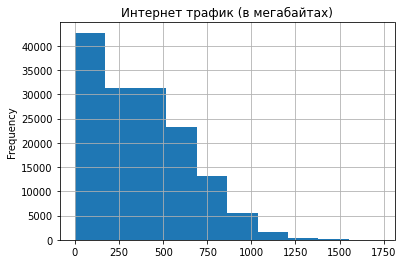

In [16]:
# Гистограмма использования интернет трафика учитывая нулевые значения
internet['mb_used'].plot(kind='hist', grid=True, title='Интернет трафик (в мегабайтах)')
print('Средняя длительность звонков: {:.2f}'.format(internet['mb_used'].mean()))
print('Медиана длительности звонков: {:.2f}'.format(internet['mb_used'].median()))
print('Стандартное отклонение: {:.2f}'.format(np.std(internet['mb_used'])))

Средняя длительность звонков: 426.09
Медиана длительности звонков: 400.54
Стандартное отклонение: 255.60


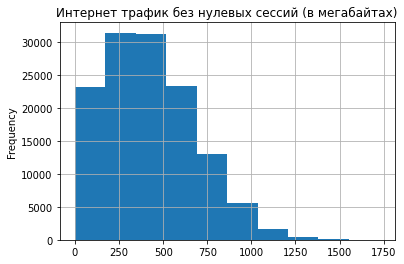

In [17]:
# Гистограмма использования интернет трафика не учитывая нулевые значения
internet.query('mb_used > 0')['mb_used'].plot(kind='hist', grid=True, title='Интернет трафик без нулевых сессий (в мегабайтах)')
print('Средняя длительность звонков: {:.2f}'.format(internet.query('mb_used > 0')['mb_used'].mean()))
print('Медиана длительности звонков: {:.2f}'.format(internet.query('mb_used > 0')['mb_used'].median()))
print('Стандартное отклонение: {:.2f}'.format(np.std(internet.query('mb_used > 0')['mb_used'])))

Мы можем наблюдать те же изменения, что и для таблицы "звонков", средний использованный интернет трафик и его медиана увеличилась, а стандартное отклонение уменшилось. А также распределение стремится к нормальному.

In [18]:
internet = internet.query('mb_used > 0').reset_index(drop=True)
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


### Таблица сообщений 'messages'

Следующая таблица для рассмотрения - <b>messages</b>

In [19]:
messages.head(50)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [20]:
messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


В данной таблице нет проблем с данными. В ней приведены лишь даты отправления сообщений.

### Таблица пользователей 'users'

In [21]:
users.head(50)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaT,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaT,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaT,Пермь,Василиса,Блинова,2018-03-22,smart


In [22]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


В данной таблице нет ничего необычного.

## Подсчет результатов для каждого пользователя

### Кол-во звонков и минут

Создадим функцию, которая принимает как аргумент сгруппированные по столбцу 'user_id' датафреймы из таблицы <b>calls</b>. К каждому датафрейму добавляется столбец <b>'month'</b>. Далее формируется сводная таблица, за индекс она принимает месяца, а за значения "длительность разговора", функция сводной таблицы - суммирование и подсчет количества значений. Для удобства отображения информации изменим названия столбцов сводной таблицы на 'duration' и 'calls_count' соответственно. Фукнция <b>возвращает сводную таблицу</b>.

Далее в переменной <b>calls_by_month</b> сохраняется общая сводная таблица по всем 'user_id'. Так как индексация в сводных таблицах внутри функции проходила по месяцам, соответственно, месяц будет являться индексом, используем метод reset_index() с параметром level='month', чтобы сделать месяца столбцом. Проверяем результат.

In [23]:
def calls_months(grouped_calls):
    grouped_calls['month'] = grouped_calls['call_date'].dt.month
    calls_by_month = grouped_calls.pivot_table(index='month', values='duration', aggfunc=['sum', 'count'])
    calls_by_month.columns = ['duration', 'calls_count']
    return calls_by_month

calls_by_month = calls.groupby('user_id').apply(calls_months)
calls_by_month.reset_index(level='month', inplace=True)
calls_by_month

,month,duration,calls_count
user_id,,,
1000,5,159.0,17
1000,6,172.0,28
1000,7,340.0,41
1000,8,408.0,42
1000,9,466.0,46
...,...,...,...
1498,10,247.0,30
1499,9,70.0,8
1499,10,449.0,44


Таблица выглядет вполне приемлимо. Теперь у нас есть информация о звонках по каждому месяца для каждого пользователя.

### Кол-во сообщений по месяцам

Проделаем те же самые шаги, как и для звонков, единственное отличие будет заключаться в том, что функцией сводной таблицы будет являться только "подсчет".

Результат функции <b>messages_months</b> записывается в переменную <b>messages_by_month</b>. Далее проделываем те же шаги, что и для звонков. Проверяем результат.

In [24]:
def messages_months(grouped_messages):
    grouped_messages['month'] = grouped_messages['message_date'].dt.month
    messages_by_month = grouped_messages.pivot_table(index='month', values='message_date', aggfunc='count')
    messages_by_month.columns = ['messages_count']
    return messages_by_month

messages_by_month = messages.groupby('user_id').apply(messages_months)
messages_by_month.reset_index(level='month', inplace=True)
messages_by_month

,month,messages_count
user_id,,
1000,5,22
1000,6,60
1000,7,75
1000,8,81
1000,9,57
...,...,...
1498,10,42
1499,9,11
1499,10,48


Теперь у нас есть информация о количестве сообщений по месяцам для каждого пользователя.

### Объем интернет-трафика по месяцам

С интернет-трафиком сделаем все по той же схеме, только функция сводной таблицы уже будет заключаться в суммировании, после этого переводим значения "МегаБайтов" в "ГигаБайты" и округляем в большую сторону, также изменяем название столбца.

Записываем результат функции в переменную <b>internet_by_month</b>. Проверяем результат.

In [25]:
def internet_months(grouped_internet):
    grouped_internet['month'] = grouped_internet['session_date'].dt.month
    internet_by_month = (grouped_internet.pivot_table(index='month', values='mb_used', aggfunc='sum') / 1024).apply(np.ceil)
    internet_by_month.columns = ['gb_used']
    return internet_by_month

internet_by_month = internet.groupby('user_id').apply(internet_months)
internet_by_month.reset_index(level='month', inplace=True)
internet_by_month

,month,gb_used
user_id,,
1000,5,3.0
1000,6,23.0
1000,7,14.0
1000,8,14.0
1000,9,15.0
...,...,...
1498,10,21.0
1499,9,2.0
1499,10,18.0


Теперь у нас есть информация об использованном интернет-трафике по каждому месяцу для каждого пользователя.

### Подсчет помесячной выручки

Для подсчета помесячной выручки сделаем следующее: вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

<b>Но</b> для начала соединим наши сводные таблицы по столбцам 'user_id' и 'month'. Заметим, что в выборке, оказывается, присутствуют пользователи, которые, например, вовсе не отправляли сообщения или не звонили, или же не использовали интернет-трафик, соответственно, в методе merge() в качестве аргумента <b>how</b> мы укажем способ <b>'outer'</b>, в таком случае в конечном датафрейме будут находиться все пользователи, а для тех, кто не использовал какую-либо услугу, этот показатель будет являться NaN. Запишем общий датафрейм в переменную c_m_i_by_month, где c - calls, m - messages, i - internet, отсортируем датафрейм по индексу. А затем присоединим к ней таблицу 'users' для определения тарифного плана.

In [26]:
c_m_i_by_month = calls_by_month.merge(messages_by_month, on=['user_id', 'month'], how='outer').merge(internet_by_month, on=['user_id', 'month'], how='outer')
c_m_i_by_month = c_m_i_by_month.merge(users, on='user_id')
c_m_i_by_month = c_m_i_by_month.set_index('user_id')
c_m_i_by_month

,month,duration,calls_count,messages_count,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,,,,,,
1000,5,159.0,17.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1000,6,172.0,28.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1000,7,340.0,41.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1000,8,408.0,42.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1000,9,466.0,46.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...
1489,8,NaN,NaN,17.0,11.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
1489,9,NaN,NaN,32.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
1489,10,NaN,NaN,21.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart


Получаем полноценный датафрейм, осталось лишь отсортировать по индексу.

In [27]:
c_m_i_by_month = c_m_i_by_month.sort_index(kind='stable')
c_m_i_by_month.reset_index(level='user_id', inplace=True)
c_m_i_by_month

,user_id,month,duration,calls_count,messages_count,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,159.0,17.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,172.0,28.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,340.0,41.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,408.0,42.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,466.0,46.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,247.0,30.0,42.0,21.0,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
3210,1499,9,70.0,8.0,11.0,2.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
3211,1499,10,449.0,44.0,48.0,18.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
3212,1499,11,612.0,62.0,59.0,18.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart


In [28]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [29]:
from tqdm import tqdm

for row in tqdm(range(c_m_i_by_month.shape[0])):
    grouped_tariff = c_m_i_by_month.loc[row, :]
    if c_m_i_by_month.loc[row, 'tariff'] == 'ultra':
        tariff = tariffs[tariffs['tariff_name'] == 'ultra']
    else:
        tariff = tariffs[tariffs['tariff_name'] == 'smart']
    over_minutes = c_m_i_by_month.loc[row, 'duration'] - int(tariff['minutes_included'])
    if np.isnan(over_minutes):
        c_m_i_by_month.loc[row, 'rubs_for_minutes'] = 0
    elif int(over_minutes) < 0:
        c_m_i_by_month.loc[row, 'rubs_for_minutes'] = 0
    else:
        c_m_i_by_month.loc[row, 'rubs_for_minutes'] = int(over_minutes) * int(tariff['rub_per_minute'])
    over_messages = c_m_i_by_month.loc[row, 'messages_count'] - int(tariff['messages_included'])
    if np.isnan(over_messages):
        c_m_i_by_month.loc[row, 'rubs_for_messages'] = 0
    elif int(over_messages) < 0:
        c_m_i_by_month.loc[row, 'rubs_for_messages'] = 0
    else:
        c_m_i_by_month.loc[row, 'rubs_for_messages'] = int(over_messages) * int(tariff['rub_per_message'])
    over_gbs = c_m_i_by_month.loc[row, 'gb_used'] - (int(tariff['mb_per_month_included']) / 1024)
    if np.isnan(over_gbs):
        c_m_i_by_month.loc[row, 'rubs_for_gbs'] = 0
    elif int(over_gbs) < 0:
        c_m_i_by_month.loc[row, 'rubs_for_gbs'] = 0
    else:
        c_m_i_by_month.loc[row, 'rubs_for_gbs'] = int(over_gbs) * int(tariff['rub_per_gb'])
    overall_profit = c_m_i_by_month.loc[row, 'rubs_for_minutes'] + c_m_i_by_month.loc[row, 'rubs_for_messages'] + c_m_i_by_month.loc[row, 'rubs_for_gbs'] + int(tariff['rub_monthly_fee'])
    c_m_i_by_month.loc[row, 'overall_profit'] = overall_profit
    

100%|██████████| 3214/3214 [00:07<00:00, 425.01it/s]


Обновляем датафрейм и проверяем результат.

In [30]:
c_m_i_by_month.head()

,user_id,month,duration,calls_count,messages_count,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,rubs_for_minutes,rubs_for_messages,rubs_for_gbs,overall_profit
0,1000,5,159.0,17.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0.0,1950.0
1,1000,6,172.0,28.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0.0,1950.0
2,1000,7,340.0,41.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0.0,1950.0
3,1000,8,408.0,42.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0.0,1950.0
4,1000,9,466.0,46.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0.0,1950.0


Мы видим обновленный датафрейм с подсчитанной помесячной выручкой.

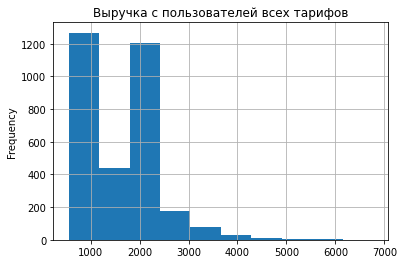

In [31]:
c_m_i_by_month['overall_profit'].plot(kind='hist', title='Выручка с пользователей всех тарифов', grid=True);

Как мы видим на гистограмме, большинство пользователей платят стандартный ежемесячный платеж по тарифам 500 и 1950 соответственно. Но есть и заядлые пользователи, которые умудряются тратить до 7000 рублей на сотовую связь.

## Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

In [32]:
smart_clients = c_m_i_by_month.query('tariff == "smart"')
ultra_clients = c_m_i_by_month.query('tariff == "ultra"')

In [33]:
c_m_i_by_month.pivot_table(index='tariff',  
                 values=['duration', 'gb_used', 'messages_count'], 
                 aggfunc=['mean', 'std', 'var']).T.style.format('{:.2f}')

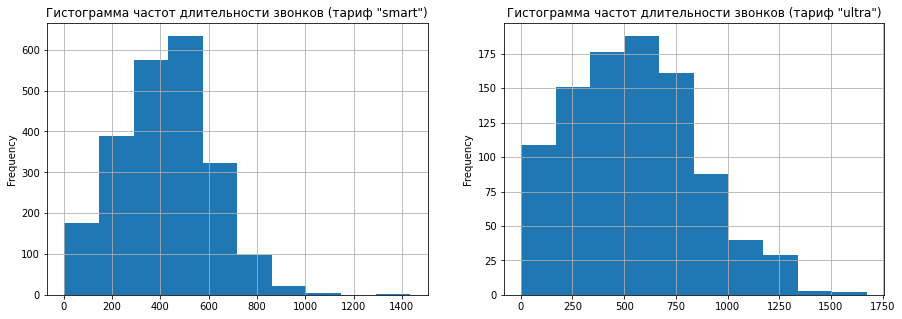

In [34]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(15,5))

smart_clients['duration'].plot(kind='hist', title='Гистограмма частот длительности звонков (тариф "smart")', grid=True, ax=axes[0]);
ultra_clients['duration'].plot(kind='hist', title='Гистограмма частот длительности звонков (тариф "ultra")', grid=True, ax=axes[1]);

<b>smart</b>

Данные близятся к нормальному распределению, но все равно, датасет является <b>отрицательно скошенным</b>. В целом, можно сказать, что большинство пользователей тарифа 'smart' укладываются в отметку в 500 бесплатных минут, включенных в стоимость тарифа.

<b>ultra</b>

Данные близятся к нормальному распределению, но все равно, датасет является <b>отрицательно скошенным</b>. В случае с тарифом 'ultra', где в стоимость тарифа включено 3000 минут бесплатного разговора в месяц, <b>никто из его пользователей не проговорил по телефону сверх лимита.</b>

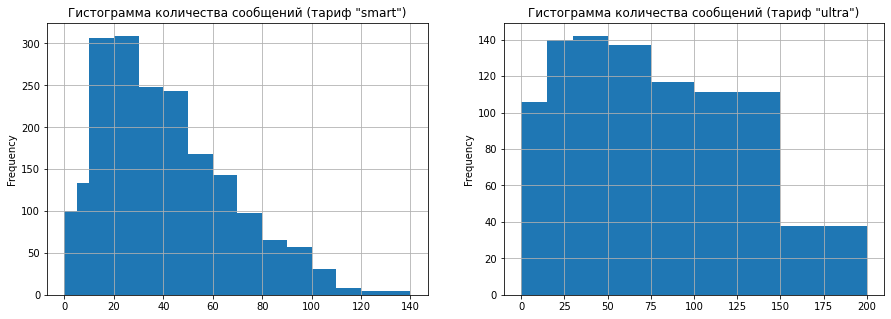

In [35]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

smart_clients['messages_count'].plot(bins=[0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140], kind='hist', title='Гистограмма количества сообщений (тариф "smart")', grid=True, ax=axes[0]);
ultra_clients['messages_count'].plot(bins=[0, 15, 30, 50, 75, 100, 150, 200], kind='hist', title='Гистограмма количества сообщений (тариф "ultra")', grid=True, ax=axes[1]);

<b>smart</b>

Датасет с <b>отрицательной скошенностью.</b> Опять же, большинство пользователей укладываются в лимит сообщений своего тарифа (50), после чего мы видим спад количества пользователей, которые отправляют больше 50 сообщений, но такие пользователи все равно есть, они как раз и приносят дополнительную прибыль оператору.

<b>ultra</b>

В случае с тарифом "ultra" активность пользователей в плане сообщений увеличилась, клиенты данного тарифа отправляют в среднем больше сообщений. Можно заметить, что все клиенты тарифа "ultra" укладываются в лимит сообщений (1000 сообщений) и не переплачивают за них.

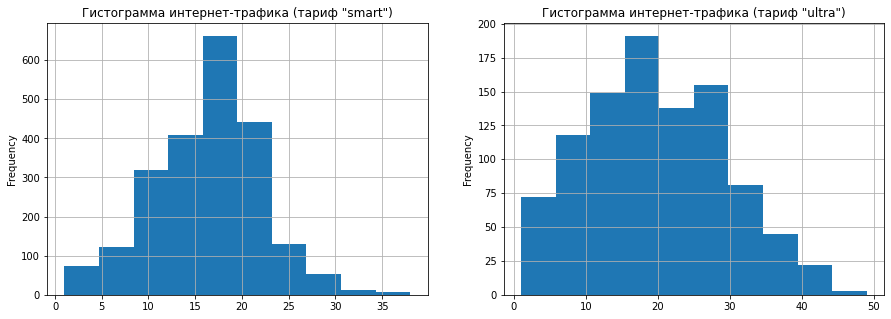

In [36]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

smart_clients['gb_used'].plot(kind='hist', title='Гистограмма интернет-трафика (тариф "smart")', grid=True, ax=axes[0]);
ultra_clients['gb_used'].plot(kind='hist', title='Гистограмма интернет-трафика (тариф "ultra")', grid=True, ax=axes[1]);

<b>smart</b>

Данные по интернет трафику практически распределены <b>нормально</b>, но все равно имеют <b>положительную скошенность</b>. По данной гистограмме видно, что заметная часть пользователей этого тарифа превышают лимит в 15 ГБ и используют интернет-трафик сверх лимита, доплачивая за это оператору.

<b>ultra</b>

Распределение <b>не является нормальным</b>. По данной гистограмме мы можем наблюдать, что некоторые пользователи превышают лимит по интернет трафику (30 ГБ), соответственно, переплачивают за него оператору. Но большинство пользователей укладываются в этот лимит, соответственно, оператору не платят за дополнительный трафик.

В целом, можно сказать, что клиенты тарифа "ultra" в основном укладываются в лимиты по всем услугам, в то время как клиенты тарифа "smart" используют минуты, сообщения, интернет-трафик сверх лимита, за что, соотвественно, доплачивают оператору.

## Проверка гипотез

Так как основная цель проекта - анализ данных с целью выявления более выгодного тарифа, зададим нулевую гипотезу, которая звучит следующим образом: <b>средняя выручка пользователей тарифов "Ультра" и "Смарт" не различается (равны)</b>
    
Гипотезы:
- H0 - средняя выручка пользователей тарифов "Ультра" и "Смарт" не различается (равны)
- H1 - средняя выручка пользователей тарифов "Ультра" и "Смарт" различается

Для проверки гипотез используем t-критерий Стьюдента, так как он чаще всего используется для проверки гипотез о равности средних значений в двух выборках. Пороговое значение уровня значимости зададим 0.05

In [37]:
alpha = 0.05

result = st.ttest_ind(smart_clients['overall_profit'], ultra_clients['overall_profit'])

print('p-значение: {}'.format(result.pvalue))

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергнуть нулевую гипотезу не удалось')

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


Уровень значимости получился: 1.42 * 10 ** -160

Соответственно, отвергаем нулевую гипотезу. <b>Можем предположить, что гипотеза H1 верна.</b>

<b>Следующие гипотезы для проверки:</b>

- H0 - средняя выручка пользователей тарифа "Смарт" больше, чем от пользователей тарифа "Ультра"
- H1 - средняя выручка пользователей тарифа "Смарт" меньше, чем от пользователей тарифа "Ультра"

Проверим эту гипотезу с помощью <b>st.ttest_1samp</b>. Интересующее нас значение будет среднее значение выручки пользователей тарифа "Ультра". Пороговое значение уровня значимости зададим 0.05.

In [38]:
alpha = 0.05

interested_value = ultra_clients['overall_profit'].mean()

result = st.ttest_1samp(smart_clients['overall_profit'], interested_value)

print('p-значение: {}'.format(result.pvalue))

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергнуть нулевую гипотезу не удалось')

p-значение: 3.363519965e-315
Отвергаем нулевую гипотезу


Уровень значимости получился: 3.36 * 10 ** -315

Соответственно, отвергаем нулевую гипотезу. <b>Можем предположить, что гипотеза H1 верна</b> и, действительно, средняя выручка от пользователей тарифа "Смарт" меньше, чем от пользователей тарифа "Ультра".

<b>Следующие гипотезы для проверки:</b>

- H0 - средняя выручка пользователей из Москвы <b>не отличается</b> от выручки пользователей из других регионов
- H1 - средняя выручка пользователей из Москвы <b>отличается</b> от выручки пользователей из других регионов

Для проверки гипотез используем t-критерий Стьюдента, так как он чаще всего используется для проверки гипотез о равности средних значений в двух выборках. Пороговое значение уровня значимости зададим 0.05. Для начала создадим выборки пользователей из Москвы и из других регионов.

In [39]:
moscow_users = c_m_i_by_month.query('city == "Москва"')
other_regions_users = c_m_i_by_month.query('city != "Москва"')

alpha = 0.05

result = st.ttest_ind(moscow_users['overall_profit'], other_regions_users['overall_profit'])

print('p-значение: {}'.format(result.pvalue))

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергнуть нулевую гипотезу не удалось')

p-значение: 0.5440152911670224
Отвергнуть нулевую гипотезу не удалось


Уровень значимости получился: 0.54. <b>Это дает основания предполагать, что нулевая (H0) гипотеза верна.</b> Вполне вероятно, что пользователи приносят одинаковую выручку что в Москве, что в остальных регионах.

## Общий вывод

<b>1.</b> Изначально, в данных не нашлось дубликатов и пропущенные значения имелись лишь в одном столбце 'churn_date' в датасете 'users'. Этот параметр отображает дату прекращения использования тарифа, если значение пропущено, значит данный клиент все еще пользовался тарифом на момент выгрузки данных.

-------------------------------------------------------------------------------------------------------------------------------

<b>2.</b> Далее, для того, чтобы отслеживать данные с точностью до месяцев, в таблицах calls, internet, messages изменили тип данных в столбцах call_date, session_date, message_date соответственно на тип 'datetime64'. Также в таблице users изменили тип данных столбцов churn_date, reg_date на тип datetime64. В дальнейшем это позволило нам создать столбец 'month' для каждой таблицы.

-------------------------------------------------------------------------------------------------------------------------------

<b>3.</b> При поиске ошибок в данных мы наткнулись на нулевые значения в таблице "calls" в столце "duration" - продолжительность звонка, вероятнее всего это пропущенные звонки, клиент просто не смог дозвониться. Произвели удаление таких данных, так как они изменяют показатели "средней продолжительности разговора" и "медианы продолжительности разговора", а также изменяют количество звонков в целом, что могло отразиться на результатах анализа данных. В данной таблице мы наблюдали "нулевые" сессии - потраченный интернет трафик составлял 0.0. Я считаю, что в действительности такое невозможно, ведь, сессия записывается, когда пользователь запускает какое-либо приложение, использующее интернет. Как правило, такие приложения начинают использовать трафик сразу же после запуска, соответственно, пускай хоть это будет 1 Кбайт, но он будет использован. Использованный трафик не может быть равен 0. Соответственно, посчитал правильным удалить сессии, в которых было использовано 0 инетрнет трафика, ведь такие еще и искажают дальнейшие значения, полученные с помощью анализа данных.

-------------------------------------------------------------------------------------------------------------------------------

<b>4.</b> Подсчет результатов для каждого пользователя производился с помощью отдельных написанных функций, которые в свою очередь возвращали обновленные датафреймы с результатами по каждой услуге и общей выручки.

-------------------------------------------------------------------------------------------------------------------------------

<b>5.</b> Анализ таких значений как среднее количество, дисперсия и стандартное отклонение для каждой услуги (минуты, сообщения, интернет-трафик) показал в основном то, что пользователи тарифа "Ультра", как правило, не превышают тарифные лимиты по всем услугам, в то время как пользователи тарифа "Смарт" иногда превышают лимиты, за что переплачивают оператору.

-------------------------------------------------------------------------------------------------------------------------------

<b>6.</b> Проверка гипотез показала, что:
   - есть основания предполагать, что средняя выручка пользователей тарифов "Ультра" и "Смарт" различается
   - есть основания предполагать, что средняя выручка пользователей тарифа "Смарт" меньше, чем от пользователей тарифа "Ультра"
   - есть основания предполагать, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
   
-------------------------------------------------------------------------------------------------------------------------------
   
<b>Общий вывод:</b>

Тариф "Ультра" является более выгодным даже не смотря на то, что пользователи этого тарифа чаще всего не превышают установленные лимиты по всем услугам. Также выручка не зависит от того, проживает клиент в Москве или в другом регионе.